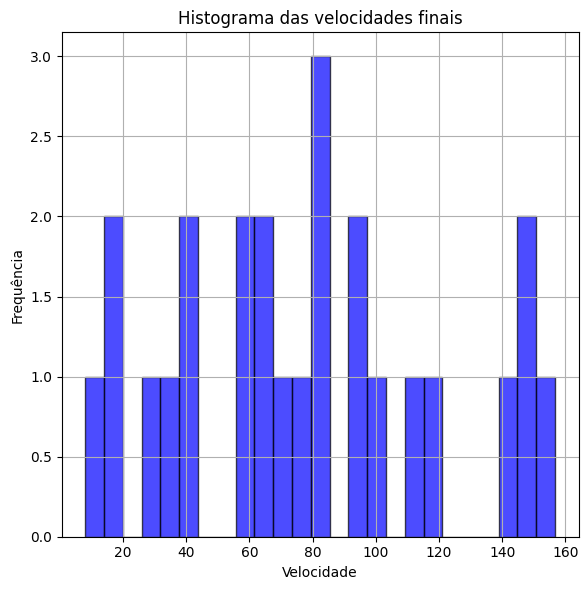

SystemExit: 

In [3]:
#Debugging 19-09-2023
#UI == pygame
#Implementado gráfico Max-Boltz
#Teste de colisao por grids ainda não implementado
#QOL == previsão de colisao em 2*dt
#Colisões funcionam (ver6.7)
#Fazer: adaptar colisões para classe


import math
import random
import warnings
import pygame
from pygame.locals import *
from sys import exit
import numpy as np
import matplotlib.pyplot as plt

# Constants
FPS = 60
dt = 1/FPS
altura_caixa = 500
largura_caixa = 500
num_particulas = 25
grid_size = 10

# Colors
WHITE = (255, 255, 255)

class Particula:
    def __init__(self, massa, raio, vel_x, vel_y, x, y, cor):
        self.massa = float(massa)
        self.raio = float(raio)
        self.vel_x = float(vel_x)
        self.vel_y = float(vel_y)
        self.x = float(x)
        self.y = float(y)
        self.cor = cor

    def deslocar(self):

        self.x += self.vel_x * dt
        self.y += self.vel_y * dt

        # Colisao parede
        if self.x < self.raio or self.x > largura_caixa - self.raio:
            self.vel_x *= -1
        if self.y < self.raio or self.y > altura_caixa - self.raio:
            self.vel_y *= -1

def check_collision(p1, p2):
    distance = math.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    if distance <= p1.raio + p2.raio:
        return True
    else:
        return False

def check_collision_future(p1, p2):
    p1_x_future = p1.x + p1.vel_x *dt*2
    p1_y_future = p1.y + p1.vel_y *dt*2
    
    p2_x_future = p2.x + p2.vel_x *dt*2
    p2_y_future = p2.y + p2.vel_y *dt*2


    #print(p1.x, p1_x_future, p1.y, p1_y_future)
    #print() #Debugging
    #print(p2.x, p2_x_future, p2.y, p2_y_future)


    distance_future = math.sqrt((p2_x_future - p1_x_future)**2 + (p2_y_future - p1_y_future)**2)
    if distance_future <= p1.raio + p2.raio:
        return True
    else:
        return False


def resolve_collision(p1, p2):
    x1 = np.array([p1.x, p1.y])
    x2 = np.array([p2.x, p2.y])

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    new_v1 = v1 - (((2 * p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2), (x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
    new_v2 = v2 - (((2 * p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1), (x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))

    p1.vel_x = new_v1[0]
    p1.vel_y = new_v1[1]
    p2.vel_x = new_v2[0]
    p2.vel_y = new_v2[1]

def gerar_particula(n_particulas, largura_caixa, altura_caixa):
    particulas = {}
    for particle_index in range(1, n_particulas + 1):
        massa = 10
        raio = 10
        vel_x = random.uniform(-100, 100)
        vel_y = random.uniform(-100, 100)
        x = random.uniform(raio, largura_caixa - raio)
        y = random.uniform(raio, altura_caixa - raio)
        #x_future = x + vel_x * dt #futura posicao
        #y_future = y + vel_y * dt
        cor = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        nome_particula = f"particula_{particle_index}" 
        particle_instance = Particula(massa, raio, vel_x, vel_y, x, y, cor)
        particulas[nome_particula] = particle_instance
    return particulas

def intersection_pos_checker(particles,iteration_max = 100):
    iteration_count = 0
    intersection = False
    for particle_name, particle_instance in particles.items():
        for other_particle_name, other_particle_instance in particles.items():
            if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                particle_move = random.choice([[particle_name,particle_instance], [other_particle_name,other_particle_instance]])
                new_x = random.uniform(particle_move[1].raio, largura_caixa - (particle_move[1].raio))
                new_y = random.uniform(particle_move[1].raio, altura_caixa - (particle_move[1].raio))
                particles[particle_move[0]].x = new_x
                particles[particle_move[0]].y = new_y
                iteration_count +=1
                #print(particles[particle_move[0]].y) #verificar coordenadas alteradas

                intersection = True
                if iteration_max == iteration_count:
                    warnings.warn(f'{iteration_max} iterações atingidas. Deve haver partículas sobrepostas. Altere o tamanho da caixa.')
                    return particles


    
    if intersection == True:
        #print('True')
        return intersection_pos_checker(particles)

    if intersection == False:
        #print('False')
        return particles

def create_particle_sprites(particles):
    sprites = pygame.sprite.Group()
    for particle_instance in particles.values():
        circle = pygame.Surface((particle_instance.raio * 2, particle_instance.raio * 2), pygame.SRCALPHA)
        pygame.draw.circle(circle, particle_instance.cor, (particle_instance.raio, particle_instance.raio), particle_instance.raio)
        sprite = pygame.sprite.Sprite()
        sprite.image = circle
        sprite.rect = sprite.image.get_rect(center=(particle_instance.x, particle_instance.y))
        sprites.add(sprite)
    return sprites

def main():
    final_speeds = []
    pygame.init()
    screen = pygame.display.set_mode((largura_caixa, altura_caixa))
    pygame.display.set_caption("Collision Simulation")

    particles = gerar_particula(num_particulas, largura_caixa, altura_caixa)
    particles = intersection_pos_checker(particles)
    sprites = create_particle_sprites(particles)

    clock = pygame.time.Clock()

    while True:
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                # Pegar velocidades finais de todas as particulas
                for particle_instance in particles.values():
                    final_speed = math.sqrt(particle_instance.vel_x**2 + particle_instance.vel_y**2)
                    final_speeds.append(final_speed)

                # Barplot/histograma das velocidades Max-Boltz.
                fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
                plt.hist(final_speeds, bins=25, color='blue', edgecolor='black', alpha=0.7)
                plt.xlabel('Velocidade')
                plt.ylabel('Frequência')
                plt.title('Histograma das velocidades finais')
                plt.grid(True)
                fig.tight_layout()
                fig.savefig("max-boltz_6_7.png")  # Salva a figura

                plt.show()
                exit()

        for particle_name, particle_instance in particles.items():
            for other_particle_name, other_particle_instance in particles.items():
                if particle_name != other_particle_name and (check_collision(particle_instance, other_particle_instance) or check_collision_future(particle_instance, other_particle_instance)):
                    resolve_collision(particle_instance, other_particle_instance)

            particle_instance.deslocar()
            #print(particle_instance.x,particle_instance.x_future) #debugging
            #print()
            #print(particle_instance.y,particle_instance.y_future)

        for sprite, particle_instance in zip(sprites, particles.values()):
            sprite.rect.center = (particle_instance.x, particle_instance.y)

        screen.fill(WHITE)
        sprites.draw(screen)

        pygame.display.flip()
        clock.tick(FPS)


if __name__ == "__main__":
    main()


## Testes

In [ ]:
def grid_collision_checker(particles, grid_size):
    # Create an empty grid
    grid = {}

    # Partition particles into grid cells
    for particle in particles:
        grid_x = int(particle.x / grid_size)
        grid_y = int(particle.y / grid_size)
        
        # Add the particle to the corresponding grid cell
        if (grid_x, grid_y) not in grid:
            grid[(grid_x, grid_y)] = []

        else:
            grid[(grid_x, grid_y)].append(particle)

    # Check for collisions within each grid cell and neighboring cells
    for cell_x in range(-1, 2): #3x3 grid division
        for cell_y in range(-1, 2):
            for (grid_x, grid_y), cell_particles in grid.items():
                neighbor_x = grid_x + cell_x
                neighbor_y = grid_y + cell_y
                
                # Check if the neighboring cell exists in the grid
                if (neighbor_x, neighbor_y) in grid:
                    neighbor_cell_particles = grid[(neighbor_x, neighbor_y)]
                    
                    # Check for collisions between particles in the current cell and the neighboring cell
                    for particle1 in cell_particles:
                        for particle2 in neighbor_cell_particles:
                            if particle1 is not particle2:
                                check_collision(particle1, particle2)
                                    #print(f"Collision detected between particles {particle1} and {particle2}.")


pygame 2.5.1 (SDL 2.28.2, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


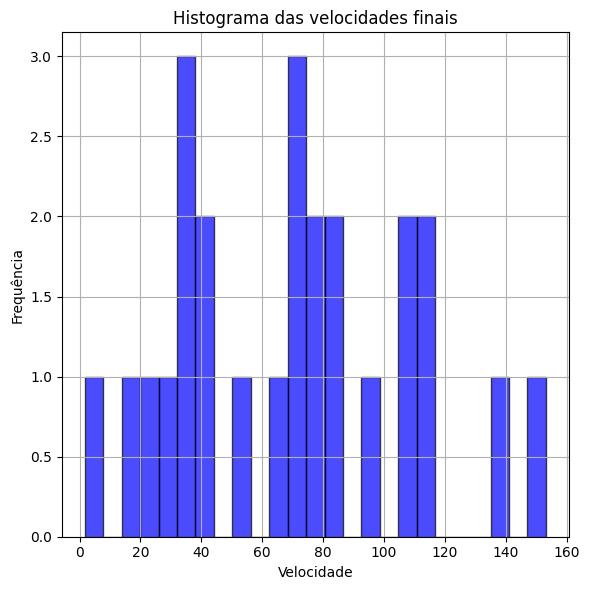

SystemExit: 

C:\venv\ilumpy-VS\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
#Debugging 19-09-2023
#UI == pygame
#Implementado gráfico Max-Boltz
#Teste de colisao por grids ainda não implementado
#QOL == previsão de colisao em 2*dt
#Colisões funcionam (ver6.7)
#Fazer: adaptar colisões para classe


import math
import random
import warnings
import pygame
from pygame.locals import *
from sys import exit
import numpy as np
import matplotlib.pyplot as plt

# Constants
FPS = 60
dt = 1/FPS
altura_caixa = 500
largura_caixa = 500
num_particulas = 25
grid_size = 10

# Colors
WHITE = (255, 255, 255)

class Particula:
    def __init__(self, massa, raio, vel_x, vel_y, x, y, cor):
        self.massa = float(massa)
        self.raio = float(raio)
        self.vel_x = float(vel_x)
        self.vel_y = float(vel_y)
        self.x = float(x)
        self.y = float(y)
        self.cor = cor

    def deslocar(self):

        self.x += self.vel_x * dt
        self.y += self.vel_y * dt

        # Colisao parede
        if self.x < self.raio or self.x > largura_caixa - self.raio:
            self.vel_x *= -1
        if self.y < self.raio or self.y > altura_caixa - self.raio:
            self.vel_y *= -1

def check_collision(p1, p2):

    p1_x_future = p1.x + p1.vel_x *dt*2
    p1_y_future = p1.y + p1.vel_y *dt*2
    
    p2_x_future = p2.x + p2.vel_x *dt*2
    p2_y_future = p2.y + p2.vel_y *dt*2

    distance_future = math.sqrt((p2_x_future - p1_x_future)**2 + (p2_y_future - p1_y_future)**2)
    distance = math.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    if ((distance <= p1.raio + p2.raio) or (distance_future <= p1.raio + p2.raio)) == True:
        return True
    else:
        return False


def resolve_collision(p1, p2):
    x1 = np.array([p1.x, p1.y])
    x2 = np.array([p2.x, p2.y])

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    new_v1 = v1 - (((2 * p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2), (x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
    new_v2 = v2 - (((2 * p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1), (x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))

    p1.vel_x = new_v1[0]
    p1.vel_y = new_v1[1]
    p2.vel_x = new_v2[0]
    p2.vel_y = new_v2[1]

def gerar_particula(n_particulas, largura_caixa, altura_caixa):
    particulas = {}
    for particle_index in range(1, n_particulas + 1):
        massa = 10
        raio = 10
        vel_x = random.uniform(-100, 100)
        vel_y = random.uniform(-100, 100)
        x = random.uniform(raio, largura_caixa - raio)
        y = random.uniform(raio, altura_caixa - raio)
        #x_future = x + vel_x * dt #futura posicao
        #y_future = y + vel_y * dt
        cor = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        nome_particula = f"particula_{particle_index}" 
        particle_instance = Particula(massa, raio, vel_x, vel_y, x, y, cor)
        particulas[nome_particula] = particle_instance
    return particulas

def intersection_pos_checker(particles,iteration_max = 100):
    iteration_count = 0
    intersection = False
    for particle_name, particle_instance in particles.items():
        for other_particle_name, other_particle_instance in particles.items():
            if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                particle_move = random.choice([[particle_name,particle_instance], [other_particle_name,other_particle_instance]])
                new_x = random.uniform(particle_move[1].raio, largura_caixa - (particle_move[1].raio))
                new_y = random.uniform(particle_move[1].raio, altura_caixa - (particle_move[1].raio))
                particles[particle_move[0]].x = new_x
                particles[particle_move[0]].y = new_y
                iteration_count +=1
                #print(particles[particle_move[0]].y) #verificar coordenadas alteradas

                intersection = True
                if iteration_max == iteration_count:
                    warnings.warn(f'{iteration_max} iterações atingidas. Deve haver partículas sobrepostas. Altere o tamanho da caixa.')
                    return particles


    
    if intersection == True:
        #print('True')
        return intersection_pos_checker(particles)

    if intersection == False:
        #print('False')
        return particles

def create_particle_sprites(particles):
    sprites = pygame.sprite.Group()
    for particle_instance in particles.values():
        circle = pygame.Surface((particle_instance.raio * 2, particle_instance.raio * 2), pygame.SRCALPHA)
        pygame.draw.circle(circle, particle_instance.cor, (particle_instance.raio, particle_instance.raio), particle_instance.raio)
        sprite = pygame.sprite.Sprite()
        sprite.image = circle
        sprite.rect = sprite.image.get_rect(center=(particle_instance.x, particle_instance.y))
        sprites.add(sprite)
    return sprites

def main():
    final_speeds = []
    pygame.init()
    screen = pygame.display.set_mode((largura_caixa, altura_caixa))
    pygame.display.set_caption("Collision Simulation")

    particles = gerar_particula(num_particulas, largura_caixa, altura_caixa)
    particles = intersection_pos_checker(particles)
    sprites = create_particle_sprites(particles)

    clock = pygame.time.Clock()

    while True:
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                # Pegar velocidades finais de todas as particulas
                for particle_instance in particles.values():
                    final_speed = math.sqrt(particle_instance.vel_x**2 + particle_instance.vel_y**2)
                    final_speeds.append(final_speed)

                # Barplot/histograma das velocidades Max-Boltz.
                fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
                plt.hist(final_speeds, bins=25, color='blue', edgecolor='black', alpha=0.7)
                plt.xlabel('Velocidade')
                plt.ylabel('Frequência')
                plt.title('Histograma das velocidades finais')
                plt.grid(True)
                fig.tight_layout()
                fig.savefig("max-boltz_6_7.png")  # Salva a figura

                plt.show()
                exit()

        for particle_name, particle_instance in particles.items():
            for other_particle_name, other_particle_instance in particles.items():
                if particle_name != other_particle_name and (check_collision(particle_instance, other_particle_instance)):
                    resolve_collision(particle_instance, other_particle_instance)

            particle_instance.deslocar()
            #print(particle_instance.x,particle_instance.x_future) #debugging
            #print()
            #print(particle_instance.y,particle_instance.y_future)

        for sprite, particle_instance in zip(sprites, particles.values()):
            sprite.rect.center = (particle_instance.x, particle_instance.y)

        screen.fill(WHITE)
        sprites.draw(screen)

        pygame.display.flip()
        clock.tick(FPS)


if __name__ == "__main__":
    main()


In [8]:
    
distance = 11
distance_future = 0.11

p1_r = 2
p2_r = 2


if ((distance <= p1_r + p1_r) or (distance_future <= p1_r + p1_r)) == True:
    print('True') 
else:
    print('False')

True
